In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, fixed

In [3]:
%matplotlib notebook
plt.rcParams.update({'font.size': 8})

<IPython.core.display.Javascript object>


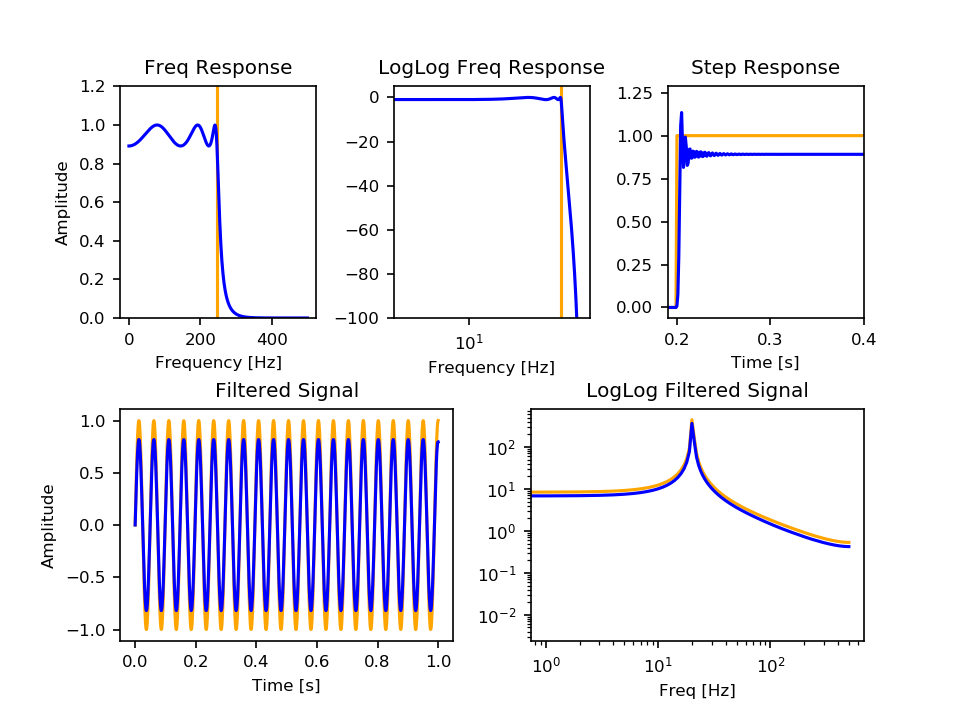

interactive(children=(Dropdown(description='filterType', options=('Bessel', 'Butterworth', 'Chebyshev'), value…

<function __main__.compareFilt(filterType, order, cutoffFreq, inputSignal, fs=200)>

In [13]:
# Set up plotting area
grid = plt.GridSpec(4, 6, wspace=1.3, hspace=1.3)
fig = plt.figure()
ax0 = fig.add_subplot(grid[0:2, 0:2])
ax1 = fig.add_subplot(grid[0:2, 2:4])
ax2 = fig.add_subplot(grid[0:2, 4:])
ax3 = fig.add_subplot(grid[2:, :3])
ax4 = fig.add_subplot(grid[2:, 3:])

ax0.set_title('Freq Response')
ax0.set_xlabel('Frequency [Hz]')
ax0.set_ylabel('Amplitude')
ax0.set_ylim(0, 1.2)

ax1.set_title('LogLog Freq Response')
ax1.set_xlabel('Frequency [Hz]')

ax2.set_title('Step Response')
ax2.set_xlabel('Time [s]')
ax2.set_xlim(0.19, 0.4)

ax3.set_title('Filtered Signal')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Amplitude')

ax4.set_title('LogLog Filtered Signal')
ax4.set_xlabel('Freq [Hz]')
    
def compareFilt(filterType, order, cutoffFreq, inputSignal, fs=200):
    """Make plots comparing different analog filters"""
    
    # set filter type
    if filterType == "Bessel":
        filterFunc = signal.bessel
    elif filterType == "Butterworth":
        filterFunc = signal.butter
    elif filterType == "Chebyshev":
        filterFunc = signal.cheby1
    else:
        raise AttributeError("filterType must be one of Bessel, Butterworth, or Chebyshev")
        
    # set input signal
    t = np.arange(fs + 1) / fs
    if inputSignal == "Noisy Sines":
        sig = (np.sin(2 * np.pi * 0.75 * t * (1-t) + 2.1) + 
               0.1 * np.sin(2 * np.pi * 1.25 * t + 1) + 
               0.18 * np.cos(2 * np.pi * 3.85 * t))
        sig = sig + np.random.randn(len(t)) * 0.08
    elif inputSignal == "Square Wave":
        sig = t * 0
        for i in range(1, 10, 2):
            sig[i*int(t.size / 10):(i+1)*int(t.size / 10)] += 1
    elif inputSignal == "Pure Sine":
        sig = np.sin(2 * np.pi * 20.25 * t)
        
    # define filter
    nyquistFreq = fs / 2
    normalizedCutoff = cutoffFreq / nyquistFreq
    
    if filterType == "Chebyshev":
        b, a = filterFunc(order, 1, cutoffFreq, fs=fs)
    else:
        b, a = filterFunc(order, cutoffFreq, fs=fs)
    w, h = signal.freqz(b, a, fs=fs)
    
    # Clear axes
    for ax in [ax0, ax1, ax2, ax3, ax4]:
        for artist in ax.lines + ax.collections:
            artist.remove()
    
    # Freq response
    ax0.axvline(cutoffFreq, color='orange')
    ax0.plot(w, np.abs(h), 'blue')
    
    
    # Log Freq Response
    ax1.axvline(cutoffFreq, color='orange')
    ax1.semilogx(w, 20 * np.log10(np.abs(h)), 'blue')
    ax1.set_ylim(-100,5)
    
    # Step Response
    step = t * 0
    step[t >= 0.2] += 1
    y = signal.lfilter(b, a, step)
    ax2.plot(t, step, color='orange')
    ax2.plot(t, y, 'blue')
    
    # Filtered Signal in Time Domain
    y = signal.filtfilt(b, a, sig)
    ax3.plot(t, sig, 'orange')
    ax3.plot(t, y, 'blue')
    
    
    # Filtered Signal in Freq Domain
    fourier = np.fft.rfft(sig)
    n = sig.size
    freq = np.fft.rfftfreq(n, d=1/fs)
    filteredFourier = np.fft.rfft(y)
    ax4.loglog(freq, np.abs(fourier), 'orange')
    ax4.loglog(freq, np.abs(filteredFourier), 'blue')
    
    
fs = 1000
interact(compareFilt, filterType=["Bessel", "Butterworth", "Chebyshev"],
         order=(1, 11, 1), cutoffFreq=(0, fs/2, 1), 
         inputSignal=["Pure Sine", "Square Wave", "Noisy Sines"], fs=fixed(fs))